In [118]:
#Importing Libraries
import os
import re
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [119]:
base_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team'

In [120]:
ensemble_models = {}

# Load VGG16 models
vgg16_folder_path = os.path.join(base_folder_path, 'VGG16', 'model_data')
for model_number in range(3):
    name = 'Model ' + str(model_number + 1)
    model_path = os.path.join(vgg16_folder_path, name)
    model_checkpoints = os.listdir(model_path)
    if not model_checkpoints:
        raise ValueError(f"No checkpoints found for {name}")
    latest_checkpoint = max(model_checkpoints, key=lambda x: int(re.findall(r'\d+', x.split('_')[0])[-1]))
    model = load_model(os.path.join(model_path, latest_checkpoint))
    ensemble_models[name] = model

# Load VGG19 models
vgg19_folder_path = os.path.join(base_folder_path, 'VGG19', 'model_data')
for model_number in range(3, 6):
    name = 'Model ' + str(model_number + 1)
    model_path = os.path.join(vgg19_folder_path, name)
    model_checkpoints = os.listdir(model_path)
    if not model_checkpoints:
        raise ValueError(f"No checkpoints found for {name}")
    latest_checkpoint = max(model_checkpoints, key=lambda x: int(re.findall(r'\d+', x.split('_')[0])[-1]))
    model = load_model(os.path.join(model_path, latest_checkpoint))
    ensemble_models[name] = model

In [121]:
imgs_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team\extracted_images\transformed_images'

validation_size = 0.5

# Get all image paths
image_paths_all = os.listdir(imgs_folder_path)

# Split into training and validation sets
split_index = int(len(image_paths_all) * validation_size)
image_paths_train = image_paths_all[:split_index]
image_paths_val = image_paths_all[split_index:]

# Print the number of images in each set
print("Training on {} images".format(len(image_paths_train)))
print("Validating on {} images".format(len(image_paths_val)))

Training on 25049 images
Validating on 25050 images


In [122]:
def preprocess(img_paths):
    images = []
    labels = []
    for img_path in img_paths:
        image = load_img(os.path.join(imgs_folder_path,img_path), target_size=(224, 224))
        image = img_to_array(image)
        image /= 255.0  # Rescale to [0, 1]
        if image.shape != (224, 224, 3):
            continue
        images.append(image)
        labels.append(float(img_path.split('_')[0]))
    return np.array(images), np.array(labels).reshape(-1, 1)

1/1 [==============================] - 1s 614ms/step
 > True Age : 63
 > Predicted Age by Model 1 : 25.3913
 > Predicted Age by Model 2 : 24.7503
 > Predicted Age by Model 3 : 25.3483
 > Predicted Age by Model 4 : 12.9026
 > Predicted Age by Model 5 : 19.9231
 > Predicted Age by Model 6 : 15.8830
 > Predicted Age by Ensembling : 20.6998


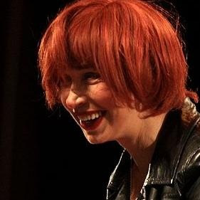

In [123]:
# Test on a random image from validation set
random_choice = np.random.choice(image_paths_val, 1)[0] # Choose a random image
test_image, _ = preprocess([random_choice]) # Preprocess image
predictions = {}
for model_name, model in ensemble_models.items():
    prediction = model.predict(test_image)
    predictions[model_name] = prediction
print(' > True Age : {}'.format(random_choice.split('_')[0]))
ensemble_avg_prediction = sum(prediction[0][0] for prediction in predictions.values()) / len(ensemble_models)
for model_name, prediction in predictions.items():
    print(' > Predicted Age by {0} : {1:.4f}'.format(model_name, prediction[0][0]))
print(' > Predicted Age by Ensembling : {0:.4f}'.format(ensemble_avg_prediction))
display(Image.open(os.path.join(imgs_folder_path, random_choice)).resize((200, 200)))

True Age: 33
1/1 [==============================] - 0s 102ms/step
Predicted Age by Model 1: 23.61
1/1 [==============================] - 0s 89ms/step
Predicted Age by Model 2: 22.35
1/1 [==============================] - 0s 105ms/step
Predicted Age by Model 3: 24.82
1/1 [==============================] - 0s 109ms/step
Predicted Age by Model 4: 14.62
1/1 [==============================] - 0s 108ms/step
Predicted Age by Model 5: 19.63
1/1 [==============================] - 0s 101ms/step
Predicted Age by Model 6: 15.51
Predicted Age by Ensembling: 20.09


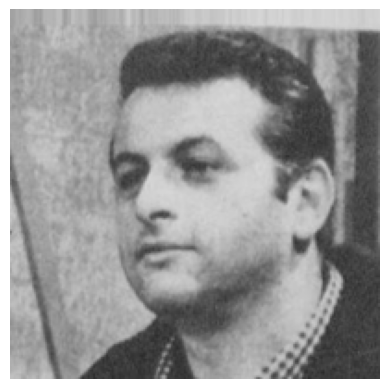

In [89]:
import matplotlib.pyplot as plt
from PIL import Image

# Test on a random image from the validation set
random_choice = np.random.choice(image_paths_val, 1)[0]  # Choose a random image
test_image, _ = preprocess([random_choice])  # Preprocess image
predictions = {}

# Display the true age
true_age = int(random_choice.split('_')[0])
print(f'True Age: {true_age}')

# Loop through each model and make predictions
for model_name, model in ensemble_models.items():
    prediction = model.predict(test_image)
    predictions[model_name] = prediction[0][0]
    print(f'Predicted Age by {model_name}: {predictions[model_name]:.2f}')

# Calculate ensemble average prediction
ensemble_avg_prediction = sum(predictions.values()) / len(predictions)
print(f'Predicted Age by Ensembling: {ensemble_avg_prediction:.2f}')

# Display the image
image = Image.open(os.path.join(imgs_folder_path, random_choice)).resize((200, 200))
plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()


True Age: 39
1/1 [==============================] - 0s 81ms/step
Predicted Age by Model 1: 28.64
1/1 [==============================] - 0s 86ms/step
Predicted Age by Model 2: 27.21
1/1 [==============================] - 0s 90ms/step
Predicted Age by Model 3: 28.97
1/1 [==============================] - 0s 112ms/step
Predicted Age by Model 4: 15.78
1/1 [==============================] - 0s 110ms/step
Predicted Age by Model 5: 18.44
1/1 [==============================] - 0s 100ms/step
Predicted Age by Model 6: 18.09
Predicted Age by Ensembling: 22.85


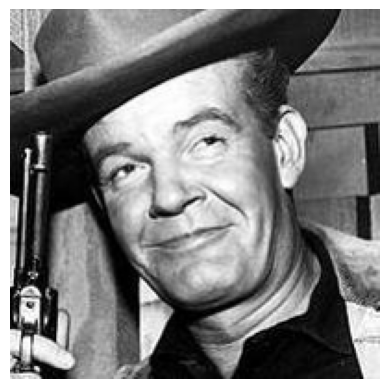

In [116]:
import matplotlib.pyplot as plt
from PIL import Image

# Test on a random image from the validation set
random_choice = np.random.choice(image_paths_val, 1)[0]  # Choose a random image
test_image, _ = preprocess([random_choice])  # Preprocess image
predictions = {}

# Display the true age
true_age = int(random_choice.split('_')[0])
print(f'True Age: {true_age}')

# Loop through each model and make predictions
for model_name, model in ensemble_models.items():
    prediction = model.predict(test_image)
    predictions[model_name] = prediction[0][0]
    print(f'Predicted Age by {model_name}: {predictions[model_name]:.2f}')

# Calculate ensemble average prediction
ensemble_avg_prediction = sum(predictions.values()) / len(predictions)
print(f'Predicted Age by Ensembling: {ensemble_avg_prediction:.2f}')

# Display the image
image = Image.open(os.path.join(imgs_folder_path, random_choice)).resize((200, 200))
plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()


1/1 [==============================] - 0s 99ms/step
True Age: 39
Predicted Age by Model 1: 24.78
Predicted Age by Model 2: 25.05
Predicted Age by Model 3: 25.40
Predicted Age by Model 4: 13.01
Predicted Age by Model 5: 18.47
Predicted Age by Model 6: 14.48
Predicted Age by Model 3: 25.40


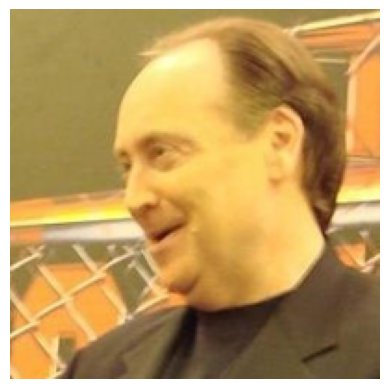

In [117]:
# Test on a random image from the validation set
random_choice = np.random.choice(image_paths_val, 1)[0]  # Choose a random image
test_image, _ = preprocess([random_choice])  # Preprocess image
predictions = {}

# Loop through each model and make predictions
for model_name, model in ensemble_models.items():
    prediction = model.predict(test_image)
    predicted_age = prediction[0][0]
    predictions[model_name] = predicted_age

# Calculate ensemble average prediction
ensemble_avg_prediction = sum(predictions.values()) / len(predictions)

# Find the predicted age closest to the true age
closest_model = min(predictions, key=lambda x: abs(predictions[x] - true_age))
closest_predicted_age = predictions[closest_model]

# Check if the ensemble average prediction is within 3 years of the true age
if abs(true_age - ensemble_avg_prediction) <= 3:
    closest_model = "Ensemble"
    closest_predicted_age = ensemble_avg_prediction

# Display the results
print(f'True Age: {true_age}')
for model_name, predicted_age in predictions.items():
    print(f'Predicted Age by {model_name}: {predicted_age:.2f}')
print(f'Predicted Age by {closest_model}: {closest_predicted_age:.2f}')

# Display the image
image = Image.open(os.path.join(imgs_folder_path, random_choice)).resize((200, 200))
plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

100%|███████████████████████████████████████████████████████████████████████| 50099/50099 [00:00<00:00, 1703461.04it/s]


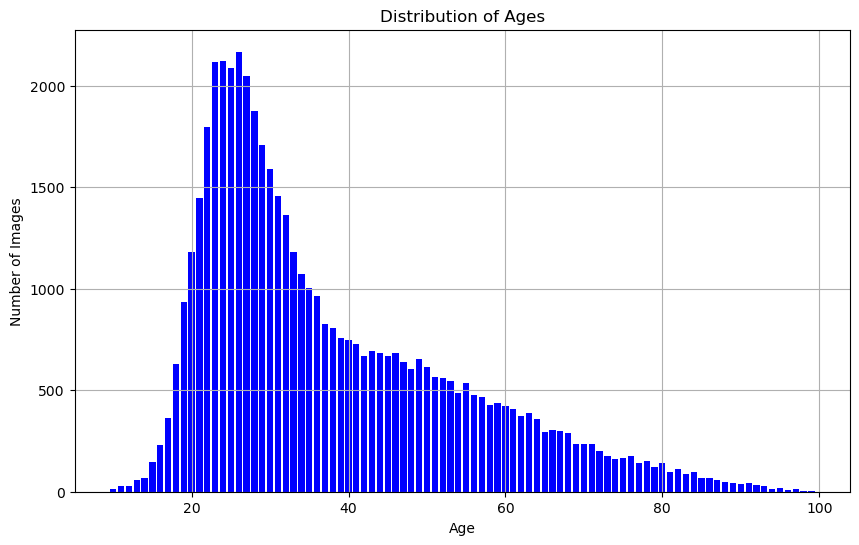

In [98]:
# Specify the local path
imgs_folder_path = r'D:\Assignment\Data Mining & Machine Learning 2\Project\Team\extracted_images\transformed_images'

# Dictionary to store the counts of each age
age_counts = {}

# Loop through the files in the folder
for _file in tqdm(os.listdir(imgs_folder_path)):
    try:
        # Split the file name to extract the age
        age = int(_file.split("_")[0])
        # Increment the count for this age
        if age in age_counts:
            age_counts[age] += 1
        else:
            age_counts[age] = 1
    except:
        pass

# Extract ages and counts for plotting
ages = list(age_counts.keys())
counts = list(age_counts.values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(ages, counts, color='blue')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.title('Distribution of Ages')
plt.grid(True)
plt.show()


In [124]:
import pandas as pd

# Lists to store data
data = {
    'True_Age': [],
    'Ensemble_Predicted_Age': []
}
for model_name in ensemble_models.keys():
    data[model_name + '_Predicted_Age'] = []

# Process 1000 images
for _ in range(500):
    # Choose a random image from the validation set
    random_choice = np.random.choice(image_paths_val, 1)[0]
    test_image, _ = preprocess([random_choice])  # Preprocess image
    predictions = {}
    true_age = int(random_choice.split('_')[0])  # True age
    
    # Make predictions for each model
    for model_name, model in ensemble_models.items():
        prediction = model.predict(test_image)
        predictions[model_name] = prediction
        data[model_name + '_Predicted_Age'].append(prediction[0][0])
    
    # Calculate ensemble predicted age
    ensemble_avg_prediction = sum(prediction[0][0] for prediction in predictions.values()) / len(ensemble_models)
    data['Ensemble_Predicted_Age'].append(ensemble_avg_prediction)
    
    # Append true age
    data['True_Age'].append(true_age)

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


1/1 [==============================] - 0s 167ms/step
     True_Age  Ensemble_Predicted_Age  Model 1_Predicted_Age  \
0          44               21.232693              26.154856   
1          39               20.102753              22.681152   
2          44               19.240674              21.311775   
3          38               20.054199              24.941441   
4          57               20.494411              23.472591   
..        ...                     ...                    ...   
495        36               20.718655              24.114645   
496        47               20.426293              24.711306   
497        63               21.108762              26.099213   
498        37               21.120796              26.737482   
499        62               21.718221              26.630651   

     Model 2_Predicted_Age  Model 3_Predicted_Age  Model 4_Predicted_Age  \
0                24.287083              26.403145              13.971018   
1                24.247683

In [125]:
df.head()

,True_Age,Ensemble_Predicted_Age,Model 1_Predicted_Age,Model 2_Predicted_Age,Model 3_Predicted_Age,Model 4_Predicted_Age,Model 5_Predicted_Age,Model 6_Predicted_Age
0,44,21.232693,26.154856,24.287083,26.403145,13.971018,19.336096,17.243961
1,39,20.102753,22.681152,24.247683,26.077612,14.251055,17.364820,15.994199
2,44,19.240674,21.311775,23.353403,26.196556,11.409119,16.567242,16.605949
3,38,20.054199,24.941441,22.452780,23.716087,12.847008,21.490707,14.877171
4,57,20.494411,23.472591,24.343454,25.392021,14.373805,17.652617,17.731977


In [128]:
# Calculate absolute errors for each model
for column in df.columns[1:]:
    df[f'{column}_Error'] = abs(df['True_Age'] - df[column])



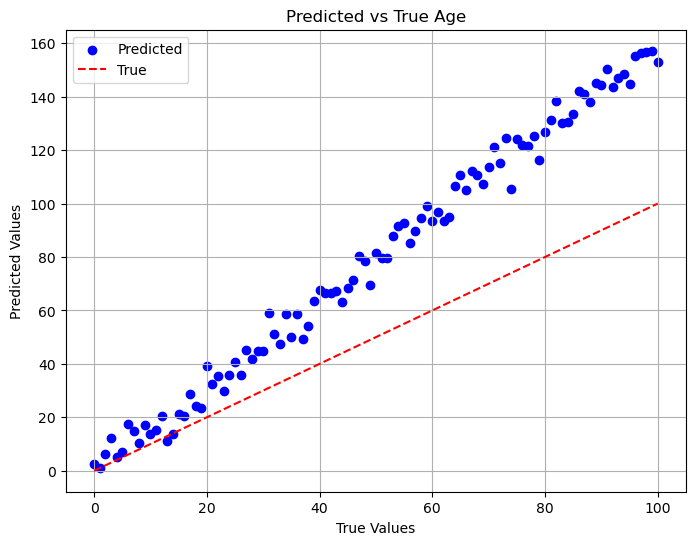

In [142]:
plt.figure(figsize=(10, 6))
plt.scatter(df['True_Age'], df['Ensemble_Predicted_Age'], color='blue', label='Predicted')
plt.plot(df['True_Age'], df['True_Age'], color='red', linestyle='--', label='True')
plt.title('True Age vs Ensemble Predicted Age')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
true_ages = df['True_Age']
predicted_ages = [df[f'Model {i}_Predicted_Age'] for i in range(1, 7)]


In [78]:
# Calculate evaluation metrics
mae_scores = [mean_absolute_error(true_ages, preds) for preds in predicted_ages]
mse_scores = [mean_squared_error(true_ages, preds) for preds in predicted_ages]
rmse_scores = [np.sqrt(mse) for mse in mse_scores]
r2_scores = [r2_score(true_ages, preds) for preds in predicted_ages]


In [79]:
for i, model_name in enumerate(range(1, 7)):
    print(f"Model {model_name}:")
    print(f"\tMAE: {mae_scores[i]}")
    print(f"\tMSE: {mse_scores[i]}")
    print(f"\tRMSE: {rmse_scores[i]}")
    print(f"\tR-squared: {r2_scores[i]}")

Model 1:
	MAE: 24.230387878417968
	MSE: 795.6042870793716
	RMSE: 28.20645825124756
	R-squared: -2.7361084154936446
Model 2:
	MAE: 25.4186845703125
	MSE: 855.6493872975747
	RMSE: 29.251485215242912
	R-squared: -3.0180764841398195
Model 3:
	MAE: 24.461227436065673
	MSE: 808.5757298402441
	RMSE: 28.43546605632206
	R-squared: -2.7970215066458985
Model 4:
	MAE: 36.22386602783203
	MSE: 1524.886505751923
	RMSE: 39.049795207554205
	R-squared: -6.160772508813915
Model 5:
	MAE: 31.58780636405945
	MSE: 1210.5261857023233
	RMSE: 34.79261682745814
	R-squared: -4.684555931919809
Model 6:
	MAE: 34.33899715805054
	MSE: 1390.8287587995953
	RMSE: 37.29381662956468
	R-squared: -5.531245638880466


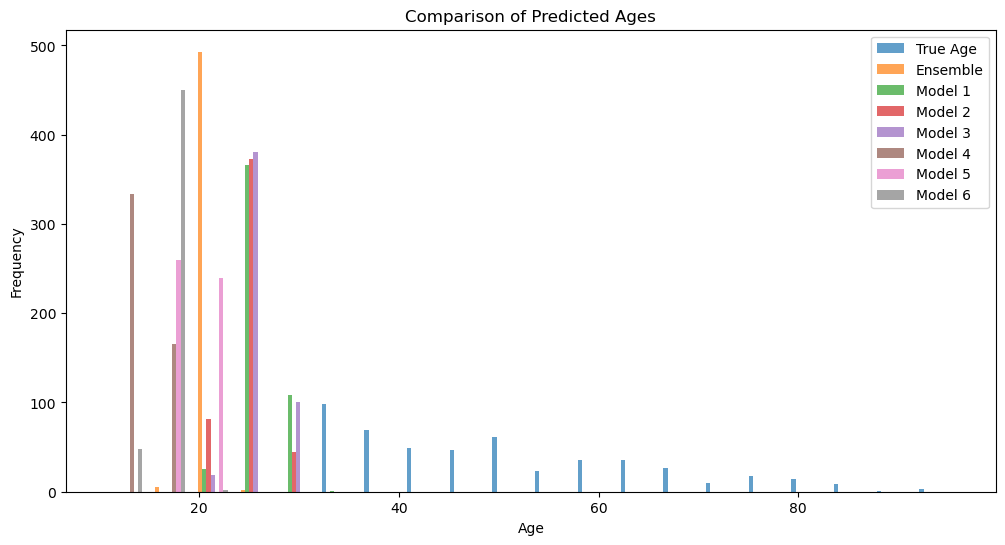

Ensemble: MAE=29.38, MSE=1072.51, RMSE=32.75
Model 1: MAE=24.23, MSE=795.60, RMSE=28.21
Model 2: MAE=25.42, MSE=855.65, RMSE=29.25
Model 3: MAE=24.46, MSE=808.58, RMSE=28.44
Model 4: MAE=36.22, MSE=1524.89, RMSE=39.05
Model 5: MAE=31.59, MSE=1210.53, RMSE=34.79
Model 6: MAE=34.34, MSE=1390.83, RMSE=37.29


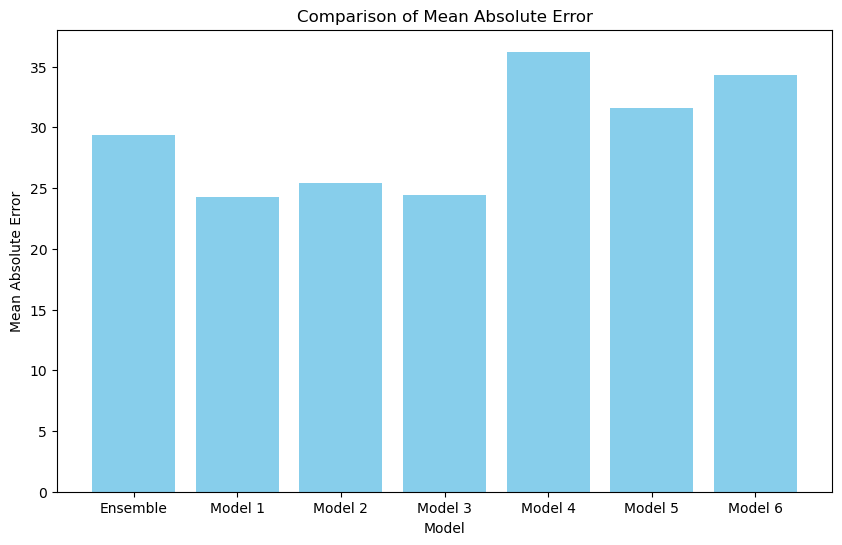

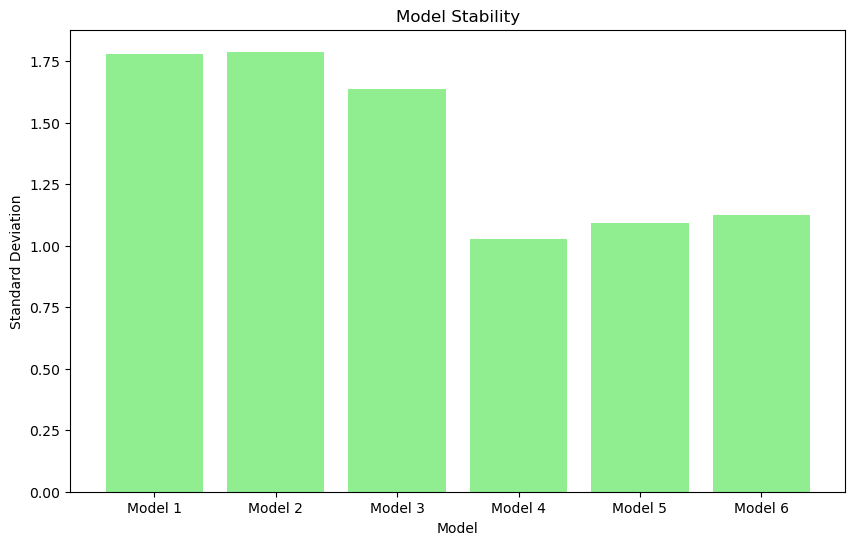

Outliers:      True_Age  Ensemble_Predicted_Age  Model 1_Predicted_Age  \
0          73               22.543434              28.241005   
1          37               21.229485              27.396164   
2          57               20.261118              25.621141   
3          34               20.153145              23.115578   
4          54               22.179759              27.077082   
..        ...                     ...                    ...   
495        34               20.633062              27.604723   
496        62               21.123119              24.572187   
497        46               19.301266              24.479588   
498        34               19.631937              23.417156   
499        34               20.458730              25.175669   

     Model 2_Predicted_Age  Model 3_Predicted_Age  Model 4_Predicted_Age  \
0                27.679771              28.136765              15.535612   
1                24.014816              25.166557              14.464

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 1. Comparison of Predicted Ages
plt.figure(figsize=(12, 6))
plt.hist([df['True_Age'], df['Ensemble_Predicted_Age'], 
          df['Model 1_Predicted_Age'], df['Model 2_Predicted_Age'],
          df['Model 3_Predicted_Age'], df['Model 4_Predicted_Age'],
          df['Model 5_Predicted_Age'], df['Model 6_Predicted_Age']], 
         bins=20, alpha=0.7, label=['True Age', 'Ensemble', 'Model 1', 'Model 2', 
                                    'Model 3', 'Model 4', 'Model 5', 'Model 6'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Comparison of Predicted Ages')
plt.legend()
plt.show()

# 2. Performance Metrics
for model in ['Ensemble', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']:
    mae = mean_absolute_error(df['True_Age'], df[model+'_Predicted_Age'])
    mse = mean_squared_error(df['True_Age'], df[model+'_Predicted_Age'])
    rmse = np.sqrt(mse)
    print(f'{model}: MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}')

# 3. Model Comparison
plt.figure(figsize=(10, 6))
models = ['Ensemble', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
mae_scores = [mean_absolute_error(df['True_Age'], df[model+'_Predicted_Age']) for model in models]
plt.bar(models, mae_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Error')
plt.show()

# 4. Model Stability
plt.figure(figsize=(10, 6))
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
std_devs = [np.std(df[model+'_Predicted_Age']) for model in models]
plt.bar(models, std_devs, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Standard Deviation')
plt.title('Model Stability')
plt.show()

# 5. Feature Importance
# If applicable, analyze feature importance using feature_importance_plot or permutation_importance

# 6. Outlier Detection
outliers = df[np.abs(df['True_Age'] - df['Ensemble_Predicted_Age']) > 10]
print('Outliers:', outliers)

# 7. Trend Analysis
# If applicable, analyze


In [143]:
df.head()

,True_Age,Ensemble_Predicted_Age,Model 1_Predicted_Age,Model 2_Predicted_Age,Model 3_Predicted_Age,Model 4_Predicted_Age,Model 5_Predicted_Age,Model 6_Predicted_Age,Ensemble_Predicted_Age_Error,Model 1_Predicted_Age_Error,...,Model 5_Predicted_Age_Error_Error,Model 6_Predicted_Age_Error_Error,Ensemble_Predicted_Age_Error_Error_Error,Model 1_Predicted_Age_Error_Error_Error,Model 2_Predicted_Age_Error_Error_Error,Model 3_Predicted_Age_Error_Error_Error,Model 4_Predicted_Age_Error_Error_Error,Model 5_Predicted_Age_Error_Error_Error,Model 6_Predicted_Age_Error_Error_Error,Ensemble_Absolute_Error
0,44,21.232693,26.154856,24.287083,26.403145,13.971018,19.336096,17.243961,22.767307,17.845144,...,19.336096,17.243961,22.767307,17.845144,19.712917,17.596855,30.028982,24.663904,26.756039,-22.0
1,39,20.102753,22.681152,24.247683,26.077612,14.251055,17.364820,15.994199,18.897247,16.318848,...,17.364820,15.994199,18.897247,16.318848,14.752317,12.922388,24.748945,21.635180,23.005801,-19.5
2,44,19.240674,21.311775,23.353403,26.196556,11.409119,16.567242,16.605949,24.759326,22.688225,...,16.567242,16.605949,24.759326,22.688225,20.646597,17.803444,32.590881,27.432758,27.394051,-22.0
3,38,20.054199,24.941441,22.452780,23.716087,12.847008,21.490707,14.877171,17.945801,13.058559,...,21.490707,14.877171,17.945801,13.058559,15.547220,14.283913,25.152992,16.509293,23.122829,-19.0
4,57,20.494411,23.472591,24.343454,25.392021,14.373805,17.652617,17.731977,36.505589,33.527409,...,17.652617,17.731977,36.505589,33.527409,32.656546,31.607979,42.626195,39.347383,39.268023,-28.5


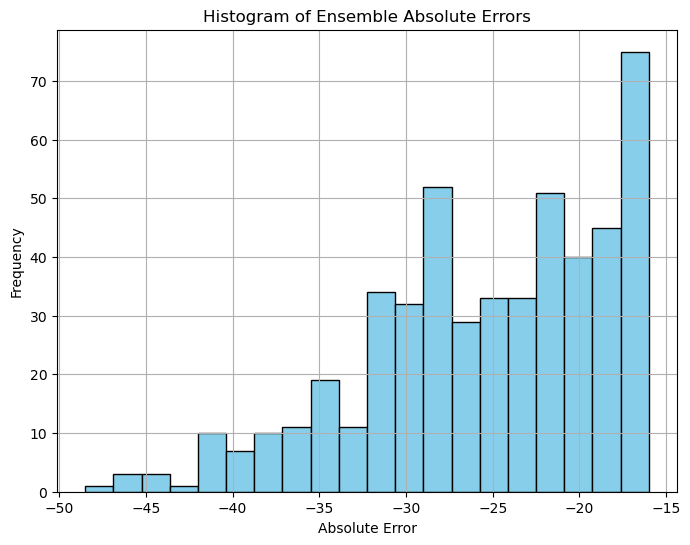

In [150]:
ensemble_absolute_error = df['Ensemble_Absolute_Error']

# Plot a histogram of absolute errors
plt.figure(figsize=(8, 6))
plt.hist(ensemble_absolute_error, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Ensemble Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()